In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from metal.contrib.slicing.synthetics.geometric_synthetics import *

In [2]:
k = 2
m = 30
n = 5000

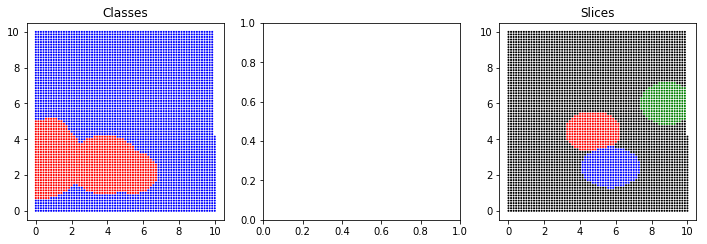

In [3]:
L, X, Y, Z = generate_dataset(k, m, n, Z_kwargs={'num_slices': 3})

### Analyze Data

In [4]:
from scipy.sparse import csr_matrix
import torch

L = csr_matrix(L)
X = torch.Tensor(X)

In [5]:
from metal.utils import split_data

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.8, 0.1, 0.1], shuffle=True, seed=123)

In [6]:
from metal.analysis import lf_summary

lf_summary(Ls[1], Ys[1])

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1, 2]",0.110,0.110,0.096,39,16,0.709091
1,"[1, 2]",0.316,0.316,0.286,92,66,0.582278
2,"[1, 2]",0.418,0.414,0.334,168,41,0.803828
3,"[1, 2]",0.218,0.210,0.162,73,36,0.669725
4,"[1, 2]",0.252,0.252,0.216,108,18,0.857143
5,"[1, 2]",0.346,0.342,0.288,118,55,0.682081
6,"[1, 2]",0.160,0.160,0.146,33,47,0.412500
7,"[1, 2]",0.080,0.074,0.042,32,8,0.800000
8,"[1, 2]",0.028,0.028,0.026,12,2,0.857143
9,"[1, 2]",0.354,0.354,0.284,128,49,0.723164


In [7]:
# num_votes = Ls[0].sum(axis=1)
# plt.hist(num_votes)

In [ ]:
# np.save('synthetic_data.npy', (L, Y))

# Learn

In [ ]:
# L, Y = np.load('synthetic_data.npy')

### Snorkel LabelModel

In [8]:
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel

label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])

Inferred cardinality: 2


In [9]:
from metal.metrics import accuracy_score

Y_train_ps = label_model.predict_proba(Ls[0])
Y_train_p = label_model.predict(Ls[0])

Y_dev_ps = label_model.predict_proba(Ls[0])
Y_dev_p = label_model.predict(Ls[1])
accuracy_score(Ys[1], Y_dev_p)

0.808

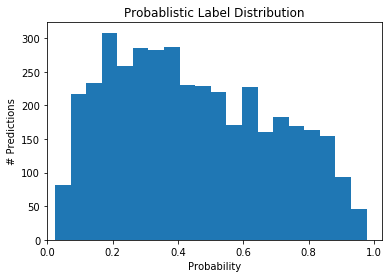

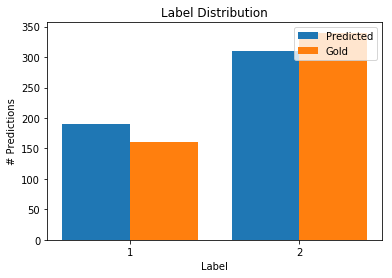

In [10]:
from metal.contrib.visualization.analysis import (
    plot_predictions_histogram, 
    plot_probabilities_histogram,
)
    
plot_probabilities_histogram(Y_dev_ps[:,0], title="Probablistic Label Distribution")
plot_predictions_histogram(Y_dev_p, Ys[1], title="Label Distribution")

## Compare Baselines

In [ ]:
# from torch.utils.data import DataLoader
# from metal.utils import SlicingDataset
# from metal.contrib.slicing.utils import evaluate_slicing

# eval_loader = DataLoader(SlicingDataset(Xs[1], Ys[1], Zs[1]))

# results = {}
# for model_name, model in trained_models.items():
#     scores = evaluate_slicing(model, eval_loader, verbose=False)
#     results[model_name] = {k:v['accuracy'] for k,v in scores.items()}
    
# import pandas as pd
# pd.DataFrame.from_dict(results)

### EndModel

In [ ]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

train_loader = DataLoader(
    SlicingDataset(Xs[0], Y_train_ps),
    batch_size=256,
    shuffle=True
)

In [ ]:
from metal.end_model import EndModel
import torch

end_model = EndModel([2,10,10,2])
end_model.train_model(train_loader, dev_data=(Xs[1], Ys[1]), l2=0.0, 
                      n_epochs=25, print_every=5, validation_metric='accuracy', 
                      disable_prog_bar=True)
end_model.score((Xs[1], Ys[1]))

### SliceModel

In [ ]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

Ls_tensors = [torch.Tensor(np.asarray(L.todense())) for L in Ls]

train_loader = DataLoader(
    SlicingDataset(Xs[0], Ls_tensors[0], Y_train_ps),
    batch_size=256,
    shuffle=True
)

dev_loader = DataLoader(
    SlicingDataset(Xs[1], Ys[1]),
    batch_size=256,
)

In [ ]:
import torch.nn as nn
from metal.contrib.slicing.online_dp import SliceDPModel, MLPModule

n, m = Ls[0].shape
input_dim = Xs[0].shape[1]

input_module = MLPModule(input_dim, 10, [10], bias=True)
slice_model = SliceDPModel(input_module, r=10, m=m, reweight=False, slice_weight=0.1, 
                           verbose=False)
slice_model.train_model(
    train_loader,
    dev_data=dev_loader,
    l2=0.0, n_epochs=50,
    print_every=5, validation_metric='accuracy',
    log_writer=None,
    verbose=True, 
    use_cuda=False,
    disable_prog_bar=True,
)

### New SliceModel

In [ ]:
from metal.contrib.slicing.online_dp import SliceHatModel

# base_model = EndModel([2,20,20,2], verbose=False)
slicer = SliceHatModel(end_model, m, slice_weight=0.1)

slicer.train_model(
    train_loader,
    dev_data=dev_loader,
    lr=0.05,
    l2=0.0, n_epochs=50,
    print_every=5, validation_metric='accuracy',
    log_writer=None,
    verbose=True, 
    use_cuda=False,
    disable_prog_bar=True,
)

In [ ]:
from metal.contrib.slicing.utils import evaluate_slicing

from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

eval_loader = DataLoader(SlicingDataset(Xs[1], Ys[1], Zs[1]))

_ = evaluate_slicing(end_model, eval_loader, verbose=False)
_ = evaluate_slicing(slice_model, eval_loader, verbose=False)
_ = evaluate_slicing(slicer, eval_loader, verbose=False)

In [ ]:
# L_pred = np.round(slicer.predict_L_proba(Xs[1]).numpy())
# L_pred[L_pred == 0] = 2
# accuracy_score(Ls[1].reshape(-1,1), L_pred.reshape(-1,1), ignore_in_gold=[0])

In [ ]:
# ((Ls[1] == L_pred).sum(axis=0)/(Ls[1] != 0).sum(axis=0)).mean()

### Repeated Trials

In [ ]:
# Grid search as necessary first


In [ ]:
from metal.utils import split_data, SlicingDataset
from metal.label_model.baselines import MajorityLabelVoter
from metal.end_model import EndModel
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
from metal.contrib.slicing.synthetics.geometric_synthetics import *
from metal.contrib.slicing.online_dp import SliceHatModel
from metal.contrib.slicing.utils import evaluate_slicing

import torch
from torch.utils.data import DataLoader

NUM_TRIALS = 3
SPLIT = 2

k = 2
m = 30
n = 5000

batchsize = 32
layer_output_dims = [2, 10, 10, 2]
slice_weight = 0.1

summary = {}
for model in ['mv', 'dp', 'up', 'me', 'sm']:
    summary[model] = {
        'overall': [],
        'slices': []
    }

for i in range(NUM_TRIALS):
    L, X, Y, Z = generate_dataset(k, m, n, plotting=True)
    Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.8, 0.1, 0.1], shuffle=True)
    
    lm = SnorkelLabelModel()
    lm.train_model(Ls[0])
    Y_train_ps = lm.predict_proba(Ls[0])

    dev_loader = DataLoader(
        SlicingDataset(Xs[1], Ys[1]),
        batch_size=256,
    )
    eval_loader = DataLoader(SlicingDataset(Xs[2], Ys[2], Zs[2]))
    
    # Train dp
    em_train_loader = DataLoader(
        SlicingDataset(Xs[0], Y_train_ps),
        batch_size=batchsize,
        shuffle=True
    )    
    
    dp = EndModel(layer_output_dims)
    dp.train_model(
        em_train_loader,
        dev_data=dev_loader,
        lr=0.05,
        l2=0.0, 
        n_epochs=50,
        print_every=5, 
        validation_metric='accuracy',
        verbose=True, 
        use_cuda=False,
        disable_prog_bar=True,
    )

    dp_results = evaluate_slicing(dp, eval_loader, verbose=False)
    summary['dp']['overall'].append(dp_results['all']['accuracy'])
    for s in range(1,5):
        summary['dp']['slices'].append(dp_results[f'slice_{s}']['accuracy'])    
    
    # Train dp_sm
    L_train = torch.Tensor(np.asarray(Ls[0].todense()))    
    sm_train_loader = DataLoader(
        SlicingDataset(Xs[0], L_train, Y_train_ps),
        batch_size=batchsize,
        shuffle=True
    )
    
    dp = EndModel(layer_output_dims) # Fresh copy to be safe
    sm = SliceHatModel(dp, m, slice_weight=slice_weight)
    sm.train_model(
        sm_train_loader,
        dev_data=dev_loader,
        lr=0.05,
        l2=0.0, 
        n_epochs=50,
        print_every=5, 
        validation_metric='accuracy',
        verbose=True, 
        use_cuda=False,
        disable_prog_bar=True,
    )
    
    sm_results = evaluate_slicing(sm, eval_loader, verbose=False)
    summary['sm']['overall'].append(sm_results['all']['accuracy'])
    for s in range(1,5):
        summary['sm']['slices'].append(sm_results[f'slice_{s}']['accuracy'])

print(summary['dp'])
print(summary['sm'])

In [41]:
from metal.contrib.slicing.online_dp import SliceHatModel, MLPModule
from metal.end_model import EndModel

dp_config = {
    "end_model_init_kwargs": {
        "layer_out_dims": [2, 10, 10, 2]
    },
    "L_weights": None
}

up_config = {
    "end_model_init_kwargs": {
        "layer_out_dims": [2, 10, 10, 2]
    },
    "upweight_search_space": {"range": [1, 5]},
    "max_search": 5
}

moe_config = {
    "base_model_class" : EndModel,
    "base_model_init_kwargs": {
        "layer_out_dims": [5, 2],
        "input_layer_config": {
            "input_relu": False,
            "input_batchnorm": False,
            "input_dropout": 0.0,
        },
        "input_module": MLPModule(**{
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
        })
    },
    "train_on_L": False,
    "mixture_of_experts": True,
    "L_weights": None
},    


sm_config = {
    "end_model_init_kwargs": {
        "layer_out_dims": [2, 10, 10, 2]
    },
    "slice_kwargs": {
        "slice_weight": 0.1,
    },
    "L_weights": None
}

model_configs = {
    "DP": dp_config,
    "UPx2=": up_config,
#     "MoE": moe_config,
    "SM": sm_config,
}

In [ ]:
from metal.contrib.slicing.experiment_utils import (
    create_data_loader,
    train_model,
    search_upweighting_models,
    eval_model
)
from collections import defaultdict


NUM_TRIALS = 1
k = 2
m = 30
n = 5000
num_slices = 3

history = defaultdict(list)
for trial in range(NUM_TRIALS):

    L, X, Y, Z, targeting_lfs_idx = generate_dataset(k, m, n, return_targeting_lfs=True)
    Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.8, 0.1, 0.1], shuffle=True)
    test_loader = create_data_loader(Ls, Xs, Ys, Zs, model_config, 'test')
    
    for model_name, model_config in model_configs.items():
        print ("-"*10, "Training", model_name, "-"*10)

        if model_name.startswith('UP'):
            model = search_upweighting_models(model_config, Ls, Xs, Ys, Zs, m, targeting_lfs_idx)
        elif model_name == 'moe':
            pass
        else:
            model = train_model(model_config, Ls, Xs, Ys, Zs, m)

        results = eval_model(model, test_loader)        
        
        # Save results
        history[model_name].append(results)

---------- Training DP ----------

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)

Inferred cardinality: 2
Saving model at iteration 0 with best score 0.760
[E:0]	Train Loss: 0.671	Dev accuracy: 0.760
Saving model at iteration 1 with best score 0.766
[E:1]	Train Loss: 0.663	Dev accuracy: 0.766
Saving model at iteration 2 with best score 0.830
[E:2]	Train Loss: 0.660	Dev accuracy: 0.830
[E:3]	Train Loss: 0.658	Dev accuracy: 0.818
Saving model at iteration 4 with best score 0.848
[E:4]	Train Loss: 0.654	Dev accuracy: 0.848
[E:5]	Train Loss: 0.652	Dev accuracy: 0.838
Saving model at iteration 6 with best score 0.868
[E:6]	Train Loss: 0.653	Dev accuracy: 0.868
[E:7]	Train Loss: 0.652	Dev accuracy: 0.854
Saving model at iteratio

100%|██████████| 16/16 [00:00<00:00, 2525.74it/s]

Saving model at iteration 9 with best score 0.900
[E:9]	Train Loss: 0.651	Dev accuracy: 0.900
Restoring best model from iteration 9 with score 0.900
Finished Training
Accuracy: 0.900
        y=1    y=2   
 l=1    176    42    
 l=2     8     274   
All: 500 examples


Accuracy: 0.882
Precision: 0.756
Recall: 0.952
F1: 0.843
        y=1    y=2   
 l=1    158    51    
 l=2     8     283   

Slice 0: 426 examples
Accuracy: 0.883
Precision: 0.758
Recall: 0.966
F1: 0.849
        y=1    y=2   
 l=1    141    45    
 l=2     5     235   

Slice 1: 16 examples
Accuracy: 1.000
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     0     16    

Slice 2: 8 examples
Accuracy: 1.000
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     0      8    

Slice 3: 24 examples
Accuracy: 1.000
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     0     24    

Slice 4: 26 examples
Accuracy: 0.654
Precision: 0.739
Recall: 0.850
F1: 0.791
        y=1    y=2   
 l=1    17      6    
 l=2     3      0    

SUMMARY (accuracies):
All: 0.882
Slice 0: 0.8826291079812206
Slice 1: 1.0
Slice 2: 1.0
Slice 3: 1.0
Slice 4: 0.6538461538461539
---------- Training UPx

100%|██████████| 16/16 [00:00<00:00, 2288.61it/s]

[E:8]	Train Loss: 0.680	Dev accuracy: 0.572
[E:9]	Train Loss: 0.681	Dev accuracy: 0.594
Restoring best model from iteration 3 with score 0.618
Finished Training
Accuracy: 0.618
        y=1    y=2   
 l=1    75     82    
 l=2    109    234   
Accuracy: 0.618
        y=1    y=2   
 l=1    75     82    
 l=2    109    234   
All: 500 examples


Accuracy: 0.596
Precision: 0.383
Recall: 0.355
F1: 0.369
        y=1    y=2   
 l=1    59     95    
 l=2    107    239   

Slice 0: 426 examples
Accuracy: 0.556
Precision: 0.322
Recall: 0.267
F1: 0.292
        y=1    y=2   
 l=1    39     82    
 l=2    107    198   

Slice 1: 16 examples
Accuracy: 1.000
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     0     16    

Slice 2: 8 examples
Accuracy: 1.000
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     0      8    

Slice 3: 24 examples
Accuracy: 0.708
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      7    
 l=2     0     17    

Slice 4: 26 examples
Accuracy: 0.769
Precision: 0.769
Recall: 1.000
F1: 0.870
        y=1    y=2   
 l=1    20      6    
 l=2     0      0    

SUMMARY (accuracies):
All: 0.596
Slice 0: 0.5563380281690141
Slice 1: 1.0
Slice 2: 1.0
Slice 3: 0.7083333333333334
Slice 4: 0.7692307692307693
--------